# Week 14 - Cell Instance Segmentation using Cellpose
## Biomedical Computer Vision Group (BMCV), <br>BioQuant, IPMB, Heidelberg University
In this notebook you will use Cellpose for cell instance segmentation in microscopy images.

The notebook consists of 4 main parts where you will:
1. [Use built-in pretrained Cellpose Models and adapt their parameters for new data](#1---using-built-in-cellpose-models)
2. [Implement and use Average Precision to evaluate instance segmentation](#2---evaluation-of-instance-segmentation)
3. [Fine-tune a Cellpose model for new data](#3---trainingfinetuning-cellpose-models)

Here you can jump to the exercises:
[Exercise 1](#exercise-1),
[Exercise 2](#exercise-2),
[Exercise 3](#exercise-3),
[Exercise 4](#exercise-4)

# 0 - Setup
## Installing Dependencies

In [ ]:
!pip install cellpose
!pip install imagecodecs # needed for loading compressed images

## Importing Packages

In [9]:
import re
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import torch
from skimage.color import label2rgb
from tifffile import imread

## Downloading datasets
We will use the CTC dataset DIC-C2DH-HeLa which is showing Differential Inference Contrast (DIC) microscopy images of HeLa cells on a flat glass surface.

The dataset contains images from two sequences of life-cell microscopy images, as well as manual and computer-generated segmentations.

## Helper functions for data handling
In the following section, three main helper functions are created:
- `download_dataset`: Downloads the DIC-C2DH-HeLa dataset and extracts it into `./exercise_data/train/DIC-C2DH-HeLa`
- `create_dataset`: Extracts all or a random sample of images and masks from a given sequence of a dataset. By specifying `suffix`, we can choose if we want to use Silver Truth (ST) or Gold Truth (GT) annotations. While GT annotations were manually created by experts, they are not available for all images and cells. ST are computed automatically and validated by experts. While they are available for all images, they might contain some segmentation errors.
- `view_dataset`: Shows overlays of loaded images and masks.

In [10]:
import io
import zipfile
from pathlib import Path

import requests

def create_url(mode, dataset):
    """
    Construct URL of CTC dataset.

    CTC datasets have a train and test dataset for each image sequence.
    """
    m = mode + "ing" if mode == "train" else mode
    return f"http://data.celltrackingchallenge.net/{m}-datasets/{dataset}.zip"

def download_dataset(base_dir, dataset_name, mode="train"):
    """
    Download and extract CTC dataset.
    """
    # setup paths
    data_dir = base_dir / mode
    dataset_dir = data_dir / dataset_name

    # check if data was already downloaded
    if dataset_dir.exists():
        print(f"Dataset {dataset_name} already exists.")
    else:
        # if data was not downloaded, yet, create folder it will be saved to and CTC url
        dataset_dir.mkdir(parents=True)
        download_url = create_url(mode, dataset_name)

        # download data and check that URL actually exists
        print(f"Downloading {mode} data from {dataset_name} ({download_url}) to {dataset_dir}/{dataset_name}.")
        r = requests.get(download_url)
        assert r.status_code == 200

        # extract zip file to data folder
        z = zipfile.ZipFile(io.BytesIO(r.content))
        z.extractall(data_dir)

    print("Download finished.")
    return dataset_dir

In [11]:
import math
import matplotlib.pyplot as plt
from skimage.color import label2rgb


def sample_frames(frames, n, random_seed):
    rng = np.random.default_rng(random_seed)
    return tuple(rng.choice(frames, n, replace=False))


def create_dataset(
    dataset_dir, sequence, suffix="ST", n=None, random_seed=11, min_cells=10, ignore=None
):
    """
    Load images and masks from a dataset directory.

    Loads n randomly selected images from a given sequence of a CTC dataset.
    """
    # create directory names
    img_dir = dataset_dir / sequence
    msk_dir = dataset_dir / f"{sequence}_{suffix}" / "SEG"
    if suffix == "ERR_SEG":
        msk_dir = msk_dir.parent

    # find out which frames have provided masks
    min_cells = min_cells or 0
    ignore = ignore or []
    frames = [
        re.search(r"\d{3}$", fp.stem).group()
        for fp in sorted(msk_dir.glob("*.tif"))
        if np.unique(imread(fp)).size > min_cells
    ]
    if ignore is not None:
        frames = np.setdiff1d(frames, ignore)

    # use all available frames or randomly sample n frames that should be used/loaded
    frames_sampled = (
        tuple(frames)
        if (n is None) or (n > len(frames))
        else sample_frames(frames, n, random_seed)
    )

    # print info on the data that will be loaded
    if (n is not None) and (n > len(frames)):
        print(
            f"Number of requested frames ({n}) exceeds the number of frames in sequence ({len(frames)}). Loading all {len(frames)} frames."
        )
    elif n is not None:
        print(
            f"Loading {len(frames_sampled)} / {len(frames)} images from sequence {sequence} of {dataset_dir.name}."
        )
        print(f"Loaded frames {sorted(frames_sampled)}")

    # load images and masks
    images = [
        imread(fp)
        for fp in sorted(img_dir.glob("*.tif"))
        if fp.stem.endswith(frames_sampled)
    ]
    masks = [
        imread(fp)
        for fp in sorted(msk_dir.glob("*.tif"))
        if fp.stem.endswith(frames_sampled)
    ]

    return images, masks, frames_sampled


def view_dataset(images, masks, title, imgs_per_row=5):
    # determine number of rows
    rows = math.ceil(len(images) / imgs_per_row)

    # create grid
    fig, axs = plt.subplots(
        ncols=imgs_per_row, nrows=rows, figsize=(2 * imgs_per_row, 2 * rows)
    )

    # plot images in grid
    for i, ax in enumerate(axs.flat):
        if i < len(images):
            overlay = label2rgb(masks[i], images[i])
            ax.imshow(overlay)
        ax.axis("off")

    fig.suptitle(title)
    fig.tight_layout()

## Additional helper functions
Here, additional functions that will be used during the notebook are created:
  - `IoU_batch`: Compute IoU for multiple images/masks.
  - `plot_counts`: Used in exercise 3 to visualize mask overlap between instance predictions and ground truth.

In [12]:
def IoU_batch(pred, gt): # just here to be usable without first part of notebook
    intersection = torch.sum(pred * gt, dim=[1, 2])
    union = (
        torch.sum(pred, dim=[1, 2])
        + torch.sum(gt, dim=[1, 2])
        - torch.sum(pred * gt, dim=[1, 2])
    )
    return torch.mean(intersection / union)

def plot_counts(counts, ignore_background=False):
    """
    Create heatmap of mask correspondence counts.

    For each predicted mask (rows) overlapping pixels
    with all GT masks (cols) are counted and plotted.
    """
    # create text for heatmap entries
    annot = np.round(counts.copy(), 2).astype(str)
    # exclude zeros for readability
    annot[counts < 0.005] = ""

    # get predicted and GT labels from count matrix
    xlabels = np.arange(counts.shape[1])
    ylabels = np.arange(counts.shape[0])

    # filter out background (i.e., label=0)
    if ignore_background:
        annot = annot[1:, 1:]
        counts = counts[1:, 1:]
        xlabels = xlabels[1:]
        ylabels = ylabels[1:]

    # create scaling for colorbar for better readability
    # number of background pixels >> number of mask pixels -> breaks colorbar
    # if percentages or IoU are given, scale between 0 and 1
    if counts.max() <= 1:
        vmax = 1
    elif not ignore_background:
        vmax = counts.max() / 10 # clip colorbar, since number of bg overlap pixels is much larger than others
    else:
        vmax = counts.max()

    # create and plot heatmap with colorbar
    plt.figure(figsize=(10, 7))
    sns.heatmap(
        counts,
        square=True,
        cmap="Blues",
        annot=annot,
        vmin=0,
        vmax=vmax,
        fmt="",
        linewidths=0.5,
        linecolor="gray",
        cbar_kws={
            "label": "Number of pixels" if counts.max() > 1 else "IoU",
            "shrink": 0.9,
        },
        xticklabels=xlabels,
        yticklabels=ylabels,
    )
    plt.xlabel("GT label")
    plt.ylabel("Predicted label")

## Downloading data and creating datasets

In [13]:
base_dir = Path("exercise_data")
dataset_name = "DIC-C2DH-HeLa"

# download_dataset returns the name of the directory, the data was downloaded to
dataset_dir = download_dataset(base_dir, dataset_name=dataset_name)

Dataset DIC-C2DH-HeLa already exists.
Download finished.


We create 3 datasets from the 2 available image sequences.
1. **Training dataset:** ST segmentations of Sequence 01 (10 images randomly sampled from 92 availble images). Note: The `ignore` argument in `create_dataset` ensures, that only frames that are not used for validation are included in the training dataset.
2. **Validation dataset:** GT segmentations of Sequence 01 (8 manually segmented images)
3. **Test dataset:** GT segmentations of Sequence _02_ (6 manually segmented images)

Note: Since GT is not available for all cells on an image, `create_dataset` only includes images with at least 10 segmentation masks (this can be changed using the `min_cells` argument).

Loading 10 / 76 images from sequence 01 of DIC-C2DH-HeLa.
Loaded frames ['003', '010', '013', '041', '043', '048', '050', '059', '062', '075']


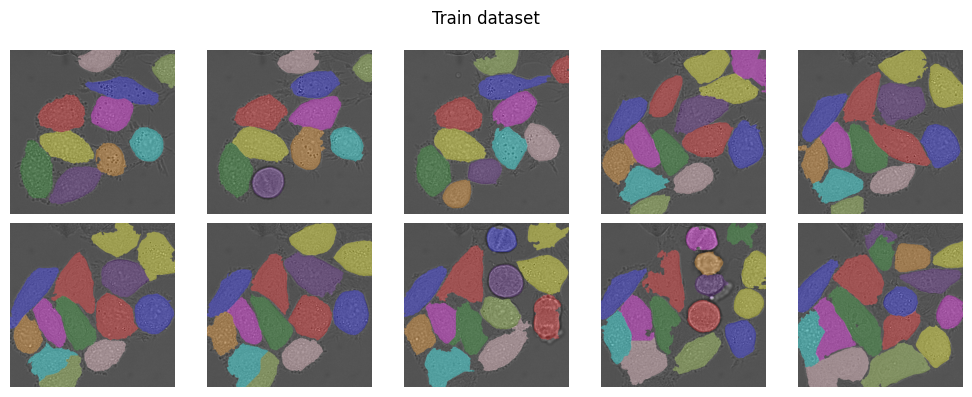

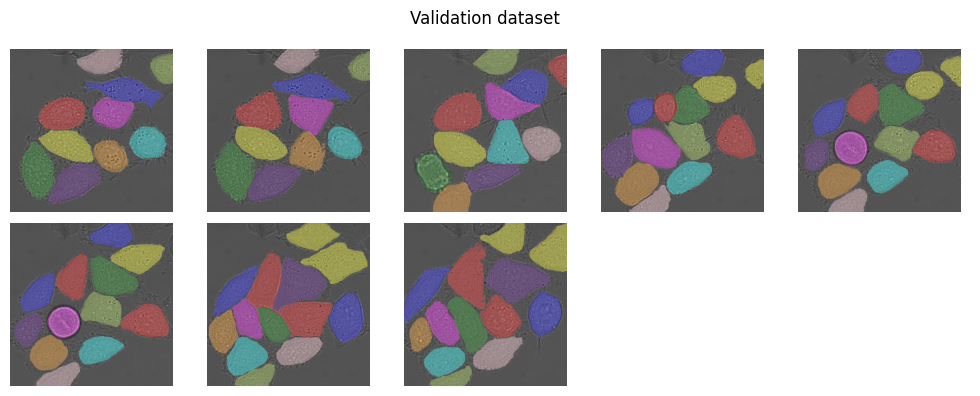

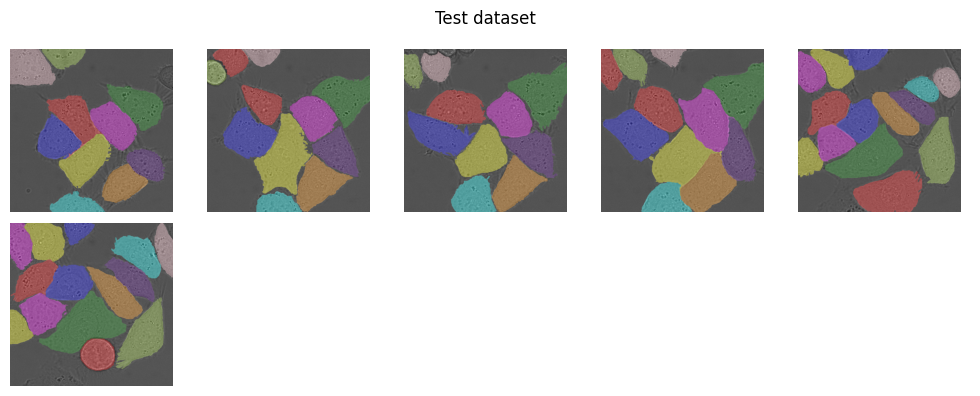

In [14]:
images_val, masks_val, frames_val = create_dataset(dataset_dir, "01", suffix="GT")
images_train, masks_train, frames_train = create_dataset(dataset_dir, "01", suffix="ST", n=10, ignore=frames_val)
images_test, masks_test, frames_test = create_dataset(dataset_dir, "02", suffix="GT")

view_dataset(images_train, masks_train, title="Train dataset")
view_dataset(images_val, masks_val, title="Validation dataset")
view_dataset(images_test, masks_test, title="Test dataset")

# 1 - Using built-in Cellpose Models
## Available Models
Cellpose includes several built-in pretrained models:
- _cyto_: Trained with original generalist Cellpose dataset (Stringer et al., Nat. Methods 2021; data seen in lecture slides)
- _cyto2_: Trained on data of _cyto_ and user-generated data that can be uploaded from the Cellpose GUI (Stringer et al., Nat. Methods 2022)
- _cyto3_: Trained on "super-generalist" dataset, that includes _cyto_ and multiple additional datasets (Stringer & Pachitariu, bioRxiv 2024)

Other built-in models can be used as well. A list of available models can be imported from `cellpose.train.MODEL_NAMES`.

## Loading a Model
Models are created/loaded with `cellpose.models.CellposeModel`.
There it is possible to load a built-in model with the `model_name` argument. When using a pretrained model, the model weights will be automatically downloaded. Furthermore, models can be trained from scratch with `pretrained_model=False`. The training device is also set in `CellposeModel` with the `gpu` argument.

The instantiated model contains additional information about the training data and process. During inference, images are resized so that the median diameter is equal for all images. This diameter is given by `CellposeModel.diam_mean`. For new data, cells will be assumed to have a diameter of `diam_mean` or a user-supplied value. The full network can be viewed with `CellposeModel.net`.

## Exercise 1
Investigate the underlying network architecture of the Cellpose model. What are the differences to the default U-Net architecture?

In [15]:
# exercise
from cellpose.models import CellposeModel

model = "Your code"
print("Loaded model!")

diameter = 0
print(f"The model expects cells with a median diameter of {diameter:.0f} pixels.")

model_architecture = "Your code"
print(model_architecture)

Loaded model!
The model expects cells with a median diameter of 0 pixels.
Your code


## Segmentation Parameters
The loaded model can be used for segmentation with the `CellposeModel.eval` method.
Here, several arguments can be adapted to tune the segmentation performance. Details can be found in the [Cellpose documentation](https://cellpose.readthedocs.io/en/latest/settings.html).

The most important ones are:
- `diameter`: Expected cell diameter. If `diameter=None`, the diameter will be set to the expected diameter of the model. It is also possible to pass a list of diameters corresponding to each image.
- `flow_threshold`: Estimates segmentation quality. Predicted flows are compared with the flows of the predicted mask. If the error of the predicted flows is above the threshold, the mask will be discarded. Defaults to `flow_threshold=0.4`.
- `cellprob_threshold`: Foreground prediction threshold. Defaults to `cellprob_threshold=0.0`. The predicted values will be converted by a sigmoid function to obtain probabilities later, so outputs have a range between -10 and 10.
- `niter`: Number of iterations in heat gradient simulation. If `niter=None`, the number will be estimated based on the cell diameter. If cells have elongated shapes, setting this too low will result in oversegmentation.
- `channels`: Image channels that should be used for segmentation. For grayscale images, set this to `[0, 0]` or `None`.

`CellposeModel.eval` expects images as a list of image `np.array`s. If passing all images in a single array, the model treats the images as a 3D-stack and will perform 3D segmentation. The model returns 3 outputs:
- Instance segmentation masks
- List with predicted flows (RGB), horizontal + vertical gradients, cell probability, and final pixel locations
- Style vectors

## Exercise 2
1. Segment the images of the test dataset using the _cyto_, _cyto2_, and _cyto3_ models. Convert the predicted masks into semantic segmentation masks and evaluate the semantic segmentation performance with the previously defined batched versions of IoU and the Dice score.
2. Investigate the predicted foreground probabilities and flows/gradients. Do they look as expected?
3. Try changing the evaluation parameters. Can model performance be increased?

Hint: You can estimate/measure the average cell diameter using masks of the training dataset or using the test images.

### Task 1

In [16]:
def view_cellpose_outputs(outputs, images, masks_true, fig_title="cyto", img_idx=0):
    masks_pred, flows_pred, styles_pred = outputs
    img = images[img_idx]

    f, (ax_gt, ax_pred, ax_flow, ax_fg) = plt.subplots(1, 4, figsize=(15, 5))
    ax_gt.imshow(label2rgb(masks_true[img_idx], img))
    ax_gt.set_title("GT masks")
    ax_gt.axis("off")

    ax_pred.imshow(label2rgb(masks_pred[img_idx], img))
    ax_pred.set_title("Predicted masks")
    ax_pred.axis("off")

    ax_flow.imshow(flows_pred[img_idx][0])
    ax_flow.set_title("Predicted flows")
    ax_flow.axis("off")

    ax_fg.imshow(torch.as_tensor(flows_pred[img_idx][2]).sigmoid().numpy(), vmin=0, vmax=1)
    ax_fg.set_title("Predicted foreground")
    ax_fg.axis("off")
    
    f.suptitle(fig_title)

In [17]:
model = CellposeModel(gpu=True, model_type="cyto")
# your code for segmentation
# view_cellpose_outputs(outputs_default, fig_title="cyto", img_idx=0)

# convert instance masks into semantic segmentation and compute IoU
# iou = IoU_batch()

# repeat for cyto2 and cyto3
# test different parameters to increase segmentation performance

### Task 2

In [24]:
model = CellposeModel(gpu=True, model_type="cyto")
# model.eval(images_test, "...")

# 2 - Evaluation of Instance Segmentation
## Average Precision
While semantic measures provide information on the overall segmentation performance, for instance segmentation it is also necessary to evaluate cell detection. For Cellpose, Average Precision (AP) is used as the main performance metric.

AP is calculated as:
$$
\text{AP}=\frac{\text{TP}}{\text{TP}+\text{FP}+\text{FN}}
$$
In order to compute True positive (TP), False positive (FP), and False negative (FN) segmentations, it is necessary to match cell instances between the predicted and GT masks.

For Cellpose, IoU is used as a matching criterion. To determine correct instance segmentations and errors, IoU is computed between each possible pair of masks.

In order to efficiently compute IoU in case of many segmentation masks per image, pixels are counted for the whole image. Here, this is implemented in the following `count_cell_pixels` function. For better visualization, the resulting matrix is plotted with `plot_counts`.

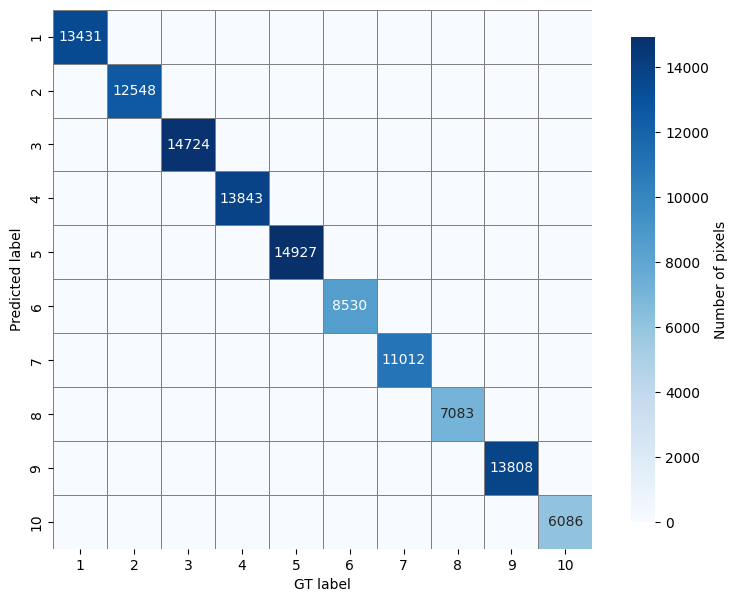

In [25]:
def count_cell_pixels(masks_pred, masks_true):
    assert (
        len(masks_pred.shape) == 2
    ), "This function expects a single pair of segmentation images."

    labels_pred = np.unique(masks_pred)
    labels_true = np.unique(masks_true)
    count_matrix = np.zeros(shape=(labels_pred.size, labels_true.size), dtype=int)

    for img_row, img_col in np.ndindex(masks_pred.shape):
        label_pred = masks_pred[img_row, img_col]
        label_true = masks_true[img_row, img_col]

        count_matrix[label_pred, label_true] += 1

    return count_matrix

# here, GT is compared with itself, change to your predicted masks
counts = count_cell_pixels(masks_test[0], masks_test[0])
plot_counts(counts, ignore_background=True)

## Exercise 3
1. Use the count matrix to compute IoU for each pair of masks. Hint: The number of predicted/GT cell pixels can be calculated as sum of the respective row/column (optional).
2. Find optimal matches between predicted and GT masks using `scipy.optimize.linear_sum_assignment` (optional).
3. Identify TP, FP and FN based for the IoU thresholds `[0.1, 0.25, 0.5, 0.75, 0.9]` and calculate the corresponding average precisions.
4. Compute the average precisions for the default built-in models and the models with adapted parameters.

Instead of implementing AP yourself (Exercise 3.1 and 3.2), you can also directly use the `cellpose.metrics.average_precision` function.

### Task 1: Convert Count Matrix to IoU Matrix (optional)
Each position of the count matrix represents the _intersection_ between the cell labels denoted by a row and column. The _union_ of these cells can then be calculated as sum of the respective row/column. Since the intersecting pixels are included in the row and column, they have to be subtracted from the union. This can be implemented using a for-loop (`iou_instance_loop`) or more efficiently using the whole matrix at once (`cellpose.metrics._intersection_over_union`)

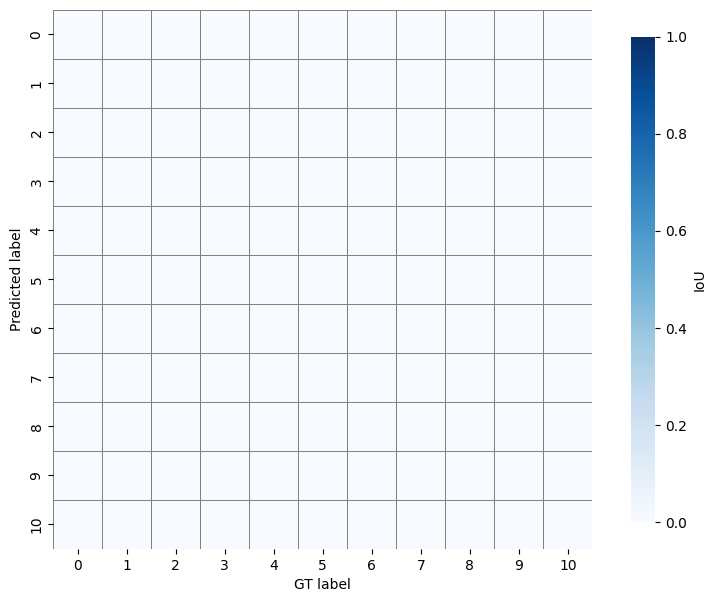

In [26]:
# exercise
def iou_instance(count_matrix):
    iou = np.zeros(count_matrix.shape)

    # your code, calculate IoU for each position of the matrix

    return iou

ious = iou_instance(counts)
plot_counts(ious)

### Task 2: Finding Matches (optional)
The default objective of `scipy.optimize.linear_sum_assignment` is to minimize the cost of assignments. Since we want to find the matches with the largest overlap, we have to pass `maximize=True` or convert IoUs to costs using `cost = 1 - iou`. AP is calculated without background, so `0` has to be excluded from the IoU matrix. Since `linear_sum_assignment` returns indices of labels, they have to be offset by `1`.

In [27]:
# exercise
from scipy.optimize import linear_sum_assignment

def match_iou(iou_matrix):
    # your code
    # hint: background should be ignored and linear_sum_assignment only returns indices and not labels

    return labels_pred, labels_true

### Task 3: Calculating AP
The number of True Positives can be identified by counting the number of matches with an IoU above the threshold. Segmentation errors are then calculated as the difference between the number of predictions/GT masks and TP.

In [ ]:
from cellpose.metrics import average_precision

# exercise (with own implementation)
def compute_ap(masks_pred, masks_true, threshold=0.5):
    n_pred = len(np.unique(masks_pred) - 1) # don't count background
    n_true = len(np.unique(masks_true) - 1)

    # your code

    return tp / (tp + fp + fn)

def average_precision_custom(masks_pred, masks_test, thresholds):
    aps = []
    for idx in range(len(masks_test)):
        counts = count_cell_pixels(masks_pred[idx], masks_test[idx])
        iou = iou_instance(counts)
        matches = match_iou(iou)
        aps.append([average_precision_custom(iou, matches, th) for th in thresholds])

    return np.mean(aps, 0)

thresholds = [0.1, 0.25, 0.5, 0.75, 0.9]
# compute AP with your own implementation
# or
# with the implementation of cellpose
ap, tp, fp, fn = average_precision(masks_pred=_, masks_true=_, threshold=thresholds)

# the output of cellpose.metrics.average_precision contains scores for all images
# for easier visualization and comparison, we average them over the whole training dataset
ap_ = np.mean(ap, axis=0)

Plot the average precision over multiple thresholds to compare the default and adapted Cellpose models.

In [29]:
def view_average_precision(thresholds, average_precisions, label):
    sns.lineplot(x=thresholds, y=average_precisions, label=label)

# 3 - Training/Finetuning Cellpose Models
## Training Parameters
To further increase segmentation performance, Cellpose models can be fine-tuned with a low number of images.

For this, first a model is instantiated as before using `cellpose.models.CellposeModel` with `model_name` set to a built-in model. It is then trained using `cellpose.train.train_seg`.

## Exercise 4
1. Fine-tune the Cellpose _cyto_ model for up to 1000 epochs.<br>**Note:** The _cyto3_ model additionally learns how to pre-process (e.g., denoise, upscale) the images. This requires considerably more training data and takes longer to train than pure segmentation.
2. Compare the performance with that of the best-performing pre-trained model using metrics for semantic and instance segmentation. For evaluation, use the same parameters.

Note: The same procedure can be used to train a `CellposeModel` from scratch with `model_type=None`. There it is recommended to also set `diam_mean` to the mean diameter of cells in the training dataset.

### Task 1: Training the Cellpose Model

In [ ]:
# exercise
from cellpose import train
from cellpose.io import logger_setup

# logger needed to see number of epochs, loss, etc.
logger = logger_setup()

model_finetuned = CellposeModel(gpu=True, model_type="cyto")
train.train_seg(
    model_finetuned.net,
    train_data=images_train,
    test_data=images_val, # don't use images_test during training
    train_labels=masks_train,
    test_labels=masks_val, # don't use masks_test during training
    channels=[0, 0],
    n_epochs=500,
    batch_size=8,
    learning_rate=0., # experiment with different values
    weight_decay=0., # experiment with different values
    SGD=False, # experiment with different optimizers
)

### Task 2: Evaluating the Fine-tuned Cellpose Model

In [ ]:
# exercise
outputs_finetuned = model_finetuned.eval()
masks_finetuned = outputs_finetuned[0]
iou = IoU_batch()

view_cellpose_outputs(outputs_finetuned, fig_title="cyto fine-tuned", img_idx=0)

In [ ]:
ap_finetuned = 

sns.lineplot(x=thresholds, y=ap_default, label="Default")
sns.lineplot(x=thresholds, y=ap_adapted, label="Adapted parameters")
sns.lineplot(x=thresholds, y=ap_finetuned, label="Fine-tuned")
plt.xlabel("IoU threshold")
plt.ylabel("Average precision")
plt.title("Average Precision")
plt.show()